# TRUST4 Exercise

This notebook contains the implementation code and descriptions of the Numenos's TRUST4 excercise. 

The notebook contains the following main sections:
1. `Parameters` - sets the different parameters
1. `Configurations` - installs and generates reference data, and installs the TRUST4 docker image
1. `Pipeline` - runs TRUST4 on a given BAM/fastaq file. The section can be executed multiple times on different BAM/fastaq files
1. `Result Evaluations` - analyzes the TRUST4 results
1. `Results Summary` - summarizes main observations
1. `Download GEO Samples` - downloads samples using the SRA tookit

### TRUST4
- an efficient tool to infer TCR and BCR repertoires from bulk RNA-seq or scRNA-seq data
- identifies potential TCR and BCR reads from raw sequence files (detects significant overlaps with V, D, J, and C genes)
- assembles candidate reads into contigs (prioritizes reads from highly expressed receptor genes)
- annotates contigs (using IMGT) and identifies V, D, J, and C genes
- determines complementary-determining region 3 (CDR3) coordinates based on IMGT

### Execution Flow
1. Run the sections `Functions and Classes`, `Parameters`, and `Configurations` once
2. Run the section `Pipeline` on a given BAM/fastaq file followed by the section `Result Evaluations`

### Challenges Encountered 
- Downloading samples from [GEO](https://www.google.com/search?client=safari&rls=en&q=GEO&ie=UTF-8&oe=UTF-8) requires (in most cases) an AWS or a Google bucket, or using the [SRA toolkit](https://github.com/ncbi/sra-tools/wiki/01.-Downloading-SRA-Toolkit). If using the SRA toolkit, one needs to know if the sample is aligned (to generate a BAM file) or un-aligned (to generate the fastaq files(s)). This information may be present in the sample page. Otherwise, use the `sra-stat --xml <sample> > info.xml` command from the SRA toolkit and look in the `<AlignInfo>` field, or the `vdb-dump --info <sample>` command

### QC Considerations
- first, make sure TRUST4 runs successfully on the provided example (compare to expected output)
- expected higher number of BCRs than TCRs 
- consistency among output files (i.e., `report.tsv`, `cdr3.out`, `annot.fa`) based on consensus ID
- consistency in number of detected genes and CDR3 among samples
- low percentage of contigs that contain the complete variable domain of the receptor (`cid_full_length` == 1) (?)
- low average read counts observed (?)
- filter out V(D)J recombination with low read counts
- comparing the diversity of the V, J, D, and C genes reported with known gene usage patterns
- compare TRUST4's results with other established reconstruction tools

### Improvements
- the pipeline is implemented in a Jupyter notebook in order to ease the review process (since it is an evaluation exercise). In general, the pipeline should be implemented in python scipts to accommodate efficient workflows and executions (e.g., job scheduling)
- the functions and classes should be implemented in `./Utils/command.py`, `./Utils/TRUSTdocker_api.py`, and `./Utils/SRAtoolkit_api.py` files
- configuration and pipeline code should be separated
- a configuration file (toml or json) should be used
- tests should be added
- workflow management framework should be considered

### Notes
- The implementation below downloads and uses the `TRUST4 docker` image to run TRUST4. Thus, make sure `docker` is installed
- Make sure `perl5` is installed

### References:
- [TRUST4 git hub](https://github.com/liulab-dfci/TRUST4)
- [SRA toolkit](https://github.com/ncbi/sra-tools/wiki/01.-Downloading-SRA-Toolkit)
- [GEO](https://www.ncbi.nlm.nih.gov/geo/)


# Table of Contents
1. [Functions and Classes](#FunctionsandClasses)
1. [Parameters](#Parameters)
1. [Configurations](#Configurations)
1. [Pipeline](#Pipeline)
1. [Result Evaluations](#resulteval)
1. [Results Summary](#resultsum)
1. [Download GEO Samples](#donaloaddata)


In [1]:
import os
import shutil
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

<a id="FunctionsandClasses"></a>
## Functions and Classes
TRUST4 docker image python interface.

In [2]:
import subprocess

type CommandOut = tuple[bool, str, str]  # command output type

def run_command(command: str, check: bool = True) -> CommandOut:
    """Execute bash shell command.

    Args:
        command (str): shell command.

    Returns:
        tuple[bool, str, str]: exit_ok, stdout, stderr.
    """
    ret = subprocess.run(command, shell=True, capture_output=True, check=check)
    return ret.returncode==0, ret.stdout.decode(), ret.stderr.decode()


class TRUSTContainer():
    """TRUST4 docker container interface."""
    def __init__(self, data_folder: str, ref_folder: str, output_folder: str, image: str, *, 
                 platform: str = 'linux/amd64') -> None:
        """Interface

        Args:
            data_folder (str): folder that holds the sample raw data
            ref_folder (str): folder that holds all reference files
            output_folder (str): folder to hold TRUST4 generated output files
            image (str): docker image name
            platform (str, optional): image platform. Defaults to 'linux/amd64'.
        """
        self.image = image
        self.bind_info: dict[str, str] = {'/data': data_folder, '/ref': ref_folder, '/out': output_folder}
        self.base_command: str = f"docker run --platform {platform} " + ' '.join(f"-v {v}:{k}" for k, v in self.bind_info.items()) + \
        f" {self.image} run-trust4"

    def usage(self) -> CommandOut:
        """Shows usage."""
        return run_command(self.base_command, check=False)

    def _generate_command(self, ref_file: str, coordinate_file: str,
                          extra_params: str | None = None) -> str:
        """Command with --ref and -f options."""
        command = self.base_command + f" --ref /ref/{ref_file} -f /ref/{coordinate_file} --od /out"
        if extra_params is not None:
            command += f" {extra_params}"
        return command

    def generate_bam_command(self, ref_file: str, coordinate_file: str, bam_file: str, 
                             extra_params: str | None = None) -> str:
        """Generates the command to analyze a BAM file."""
        return self._generate_command(ref_file, coordinate_file, extra_params=extra_params) + f" -b /data/{bam_file}"
    
    def generate_paired_fastaq_command(self, ref_file: str, coordinate_file: str, fasta_file1: str, fasta_file2: str, 
                                       extra_params: str | None = None) -> str:
        """Generates a command to analyze paired fastaq files."""
        return self._generate_command(ref_file, coordinate_file, extra_params=extra_params) + f" -1 /data/{fasta_file1} -2 /data/{fasta_file2}"
    
    def generate_single_fastaq_command(self, ref_file: str, coordinate_file: str, fasta_file: str,
                                       extra_params: str | None = None) -> str:
        """Generates a command to analyze single fastaq file."""
        return self._generate_command(ref_file, coordinate_file, extra_params=extra_params) + f" -u /data/{fasta_file}"

    def run_bam(self, ref_file: str, coordinate_file: str, bam_file: str,
                extra_params: str | None = None) -> CommandOut:
        """Runs TRUST4 on a BAM input file."""
        return run_command(
            self.generate_bam_command(ref_file, coordinate_file, bam_file, extra_params=extra_params)
        )

    def run_paired_fastaq(self, ref_file: str, coordinate_file: str, fasta_file1: str, fasta_file2: str,
                          extra_params: str | None = None) -> CommandOut:
        """Runs TRUST4 on paired fastaq files."""
        return run_command(
            self.generate_paired_fastaq_command(ref_file, coordinate_file, fasta_file1, fasta_file2, extra_params=extra_params)
        )
    
    def run_single_fastaq(self, ref_file: str, coordinate_file: str, fasta_file: str,
                          extra_params: str | None = None) -> CommandOut:
        """Runs TRUST4 on a fastaq file."""
        return run_command(
            self.generate_single_fastaq_command(ref_file, coordinate_file, fasta_file, extra_params=extra_params)
        )
    
    def __repr__(self) -> str:
        return f"TRUSTContainer('{self.bind_info['/data']}', '{self.bind_info['/ref']}', '{self.bind_info['/out']}', '{self.image}')"

    def __str__(self) -> str:
        return "TRUST4 docker container interface.\n"


<a id="Parameters"></a>
## Parameters


In [ ]:
# folder to hold the analysis figures 
figure_path: Path = Path('./Figures')

# folder to hold all reference files
reference_path: Path = Path('./Reference')

# reference files
genecode_file: Path = reference_path / 'genecode_annotation.gtf'  # annotation file
hg38_ref_file: Path = reference_path / 'Homo_sapients_GRCh38.fa'  # hg38 reference genome fasta file
VDJC_gene_ref_file: Path = reference_path / 'IMGT+C.fa'  # reference database sequence (for the --ref file)

# BCR and TCR sequences and names
bcr_tcr_gene_name_file: Path = reference_path / 'bcr_tcr_gene_name.txt'  # BCR and TCR gene names (required for generating the -f file)
bcr_tcr_gene_seq_file: Path = reference_path / 'bcrtcr.fa'  # genomic sequence and coordinate of V,J,C genes (-f option (when using BAM files))

# TRUST4 docker
data_path: str = os.path.abspath('./Data')  # BAM/fastaq files folders
ref_path: str = os.path.abspath(reference_path)  # reference files folder
out_path: str = os.path.abspath('./Output')  # output files folder
docker_container: str = 'quay.io/biocontainers/trust4:1.1.5--h5ca1c30_0'

# SRA toolkit folder
sra_command_path: str = './Tools/sratoolkit.3.2.1/bin'

# samtools execution command
samtools_path: str = str(shutil.which('samtools'))

<a id="Configurations"></a>
## Configurations
Run this section once to load and generate configurations files and load the TRUST4 docker image.

In [ ]:
# download genecode annotation file
command = f"wget -qO- https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_47/gencode.v47.annotation.gtf.gz | gunzip > {genecode_file}"
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# download Ensembl GRCh38 genome
command = f"wget -qO- https://ftp.ensembl.org/pub/release-113/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz | gunzip > \
    {hg38_ref_file}"
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# create the --ref file
command = f"perl BuildImgtAnnot.pl Homo_sapien > {VDJC_gene_ref_file}"
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# generate BCR and TCR gene names (needed for generating the -f file)
command = f"""grep ">" {VDJC_gene_ref_file} | cut -f2 -d'>' | cut -f1 -d'*' | sort | uniq > {bcr_tcr_gene_name_file}"""
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# create the BCR and TCR sequences (for the -f option)
command = f"perl BuildDatabaseFa.pl {hg38_ref_file} {genecode_file} {bcr_tcr_gene_name_file} > {bcr_tcr_gene_seq_file}"
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# Get the TRUST4 docker image. Make sure docker is installed.
command = f"docker pull {docker_container}"
ret, stdout, stderr = run_command(command)
print(ret)

# verify
!docker image ls | grep {docker_container.split(':')[0]}

## Verify (Optional)
We run `TRUST4` on the provided example to make sure TRUST4 is running properly.

In [4]:
# first show TRUST4 usage
example_data_path: str = os.path.abspath('./example')
example_ref_path: str = os.path.abspath('./')
example_out_path: str = os.path.abspath('./example/Output')
# -----------------------------------
trust4c_exp = TRUSTContainer(example_data_path, example_ref_path, example_out_path, docker_container)
ret, stdout, stderr = trust4c_exp.usage()
print(stdout, stderr, sep='\n')


TRUST4 v1.1.5-r573 usage: ./run-trust4 [OPTIONS]:
Required:
	-b STRING: path to bam file
	-1 STRING -2 STRING: path to paired-end read files
	-u STRING: path to single-end read file
	-f STRING: path to the fasta file coordinate and sequence of V/D/J/C genes
Optional:
	--ref STRING: path to detailed V/D/J/C gene reference file from IMGT database. (default: not used but recommended)
	-o STRING: prefix of output files. (default: inferred from file prefix)
	--od STRING: the directory for output files. (default: ./)
	-t INT: number of threads (default: 1)
	-k INT: the starting k-mer size for indexing contigs (default: 9)
	--barcode STRING: if -b, bam field for barcode; if -1 -2/-u, file containing barcodes (default: not used)
	--barcodeLevel STRING: barcode is for cell or molecule (default: cell)
	--barcodeWhitelist STRING: path to the barcode whitelist (default: not used)
	--barcodeTranslate STRING: path to the barcode translate file (default: not used)
	--UMI STRING: if -b, bam field for

In [5]:
# now run on the example BAM file (with provided reference files)
bam_file: Path = Path('example.bam')
# -----------------------------------
ret, stdout, stderr = trust4c_exp.run_bam('human_IMGT+C.fa', 'hg38_bcrtcr.fa', bam_file.name)
print(ret, stdout, stderr, sep='\n')


True

[Mon Apr  7 16:13:41 2025] TRUST4 v1.1.5-r573 begins.
[Mon Apr  7 16:13:41 2025] SYSTEM CALL: /usr/local/bin/bam-extractor -b /data/example.bam -t 1 -f /ref/hg38_bcrtcr.fa -o /out/TRUST_example_toassemble 
[Mon Apr  7 16:13:41 2025] Start to extract candidate reads from bam file.
[Mon Apr  7 16:13:41 2025] Finish obtaining the candidate read ids.
[Mon Apr  7 16:13:42 2025] Finish extracting reads.
[Mon Apr  7 16:13:42 2025] SYSTEM CALL: /usr/local/bin/trust4  -f /ref/hg38_bcrtcr.fa -o /out/TRUST_example -1 /out/TRUST_example_toassemble_1.fq -2 /out/TRUST_example_toassemble_2.fq
[Mon Apr  7 16:13:42 2025] Start to assemble reads.
[Mon Apr  7 16:13:42 2025] Found 394 reads.
[Mon Apr  7 16:13:42 2025] Finish sorting the reads.
[Mon Apr  7 16:13:42 2025] Finish rough annotations.
[Mon Apr  7 16:13:42 2025] Assembled 394 reads.
[Mon Apr  7 16:13:42 2025] Try to rescue 0 reads for assembly.
[Mon Apr  7 16:13:42 2025] Rescued 0 reads.
[Mon Apr  7 16:13:42 2025] Extend assemblies by mate

In [6]:
# verify
!bash mytrust_example_test.sh

TRUST4 is ready to use.


In [ ]:
# now use the provided paired fastaq files
ret, stdout, stderr = trust4c_exp.run_paired_fastaq('human_IMGT+C.fa', 'hg38_bcrtcr.fa', 'example_1.fq', 'example_2.fq')
print(ret, stdout, stderr, sep='\n')

True

[Mon Apr  7 16:13:45 2025] TRUST4 v1.1.5-r573 begins.
[Mon Apr  7 16:13:45 2025] SYSTEM CALL: /usr/local/bin/fastq-extractor -t 1 -f /ref/hg38_bcrtcr.fa -o /out/TRUST_example_1_toassemble  -1 /data/example_1.fq -2 /data/example_2.fq
[Mon Apr  7 16:13:45 2025] Start to extract candidate reads from read files.
[Mon Apr  7 16:13:45 2025] Finish extracting reads.
[Mon Apr  7 16:13:45 2025] SYSTEM CALL: /usr/local/bin/trust4  -f /ref/hg38_bcrtcr.fa -o /out/TRUST_example_1 -1 /out/TRUST_example_1_toassemble_1.fq -2 /out/TRUST_example_1_toassemble_2.fq
[Mon Apr  7 16:13:46 2025] Start to assemble reads.
[Mon Apr  7 16:13:46 2025] Found 394 reads.
[Mon Apr  7 16:13:46 2025] Finish sorting the reads.
[Mon Apr  7 16:13:46 2025] Finish rough annotations.
[Mon Apr  7 16:13:46 2025] Assembled 394 reads.
[Mon Apr  7 16:13:46 2025] Try to rescue 0 reads for assembly.
[Mon Apr  7 16:13:46 2025] Rescued 0 reads.
[Mon Apr  7 16:13:46 2025] Extend assemblies by mate pair information.
[Mon Apr  7 16

In [8]:
# verify
!bash mytrust_example1_test.sh

TRUST4 is ready to use.


In [9]:
# show generated report
report_file: Path = Path(example_out_path) / f'TRUST_{bam_file.stem}_report.tsv'
df = pd.read_csv(report_file, sep='\t').rename(columns={'#count': 'count'})
display(df)

,count,frequency,CDR3nt,CDR3aa,V,D,J,C,cid,cid_full_length
0,8,0.083333,TGTGCGAGAGGGCAGGACGGTGACTACGTGGGCGAGCCCGGGGAGT...,out_of_frame,IGHV1-3*01,IGHD1-26*01,IGHJ6*04,.,assemble1,0
1,6,0.062500,TGTGCGAGGGGGCGAACGATAATATTGTAGTAGTACCAGCTGCTAT...,out_of_frame,IGHV4-61*01,IGHD2-2*01,IGHJ3*02,.,assemble2,0
2,5,0.052083,TGTGCGAGAGATGGTACCCCGGATGTAGTAGTACCAGCTGCTATGT...,out_of_frame,IGHV4-59*01,IGHD2-2*01,IGHJ4*02,IGHM,assemble22,0
3,4,0.041667,GGGGTATTACGATTTTTGGAGTGGTTATAAAAGCGGGGGTACTACT...,GVLRFLEWL_KRGYYYYGMDVW,IGHV3-48*04,IGHD3-3*01,IGHJ6*02,IGHM,assemble10,0
4,3,0.031250,TGTGCGAGAAATGGGAGTTCGGATTTTGATCCAATCTCCTCGGGGG...,out_of_frame,IGHV1-18*01,IGHD2-15*01,IGHJ6*04,IGHM,assemble13,0
5,3,0.031250,TGTGCGAGCGCAGCACGGGATATTGTAGTGGTGGTAGCTGCTACGG...,out_of_frame,IGHV3-11*04,IGHD2-15*01,IGHJ4*02,IGHM,assemble27,0
6,3,0.031250,TGTGCGAGACAAGTGGGAGCGACCCTCATGATGCTTTTGATATCTGG,out_of_frame,IGHV5-51*01,IGHD1-26*01,IGHJ3*02,IGHM,assemble11,0
7,3,0.031250,TGTGCAAGAGATGTAGGAGGGGTATTTCCATTGTAGTGGTGGTAGC...,CARDVGGVFPL_WW_LLCWFDPW,IGHV3-74*01,IGHD2-15*01,IGHJ5*02,IGHM,assemble26,0
8,3,0.031250,TGTGCGAGAAAACCGACCCGGAAACGGATATTGTAGTGGTGGTAGC...,out_of_frame,IGHV3-69-1*01,IGHD2-15*01,IGHJ5*02,.,assemble12,0
9,3,0.031250,TGTGCGAGACCCTATAGCAGCAGCTGGTACGAAAGTTTACTACTAC...,out_of_frame,IGHV1-3*01,IGHD6-13*01,IGHJ6*02,IGHM,assemble37,0


In [10]:
# now run with generated reference files
trust4c = TRUSTContainer(data_path, ref_path, out_path, docker_container)
ret, stdout, stderr = trust4c.run_bam(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, bam_file.name)
print(ret, stdout, stderr, sep='\n')

True

[Mon Apr  7 16:13:55 2025] TRUST4 v1.1.5-r573 begins.
[Mon Apr  7 16:13:55 2025] SYSTEM CALL: /usr/local/bin/bam-extractor -b /data/example.bam -t 1 -f /ref/bcrtcr.fa -o /out/TRUST_example_toassemble 
[Mon Apr  7 16:13:55 2025] Start to extract candidate reads from bam file.
[Mon Apr  7 16:13:55 2025] Finish obtaining the candidate read ids.
[Mon Apr  7 16:13:55 2025] Finish extracting reads.
[Mon Apr  7 16:13:56 2025] SYSTEM CALL: /usr/local/bin/trust4  -f /ref/bcrtcr.fa -o /out/TRUST_example -1 /out/TRUST_example_toassemble_1.fq -2 /out/TRUST_example_toassemble_2.fq
[Mon Apr  7 16:13:56 2025] Start to assemble reads.
[Mon Apr  7 16:13:56 2025] Found 394 reads.
[Mon Apr  7 16:13:56 2025] Finish sorting the reads.
[Mon Apr  7 16:13:56 2025] Finish rough annotations.
[Mon Apr  7 16:13:56 2025] Assembled 394 reads.
[Mon Apr  7 16:13:56 2025] Try to rescue 0 reads for assembly.
[Mon Apr  7 16:13:56 2025] Rescued 0 reads.
[Mon Apr  7 16:13:56 2025] Extend assemblies by mate pair info

In [11]:
# show example generated report
report_file: Path = Path(out_path) / f'TRUST_{bam_file.stem}_report.tsv'
df = pd.read_csv(report_file, sep='\t').rename(columns={'#count': 'count'})
display(df)

,count,frequency,CDR3nt,CDR3aa,V,D,J,C,cid,cid_full_length
0,8,0.082474,TGTGCGAGAGGGCAGGACGGTGACTACGTGGGCGAGCCCGGGGAGT...,out_of_frame,IGHV1-3*01,IGHD1-26*01,IGHJ6*03,.,assemble1,0
1,6,0.061856,TGTGCGAGGGGGCGAACGATAATATTGTAGTAGTACCAGCTGCTAT...,out_of_frame,IGHV4-61*01,IGHD2-2*01,IGHJ3*02,.,assemble2,0
2,5,0.051546,TGTGCGAGAGATGGTACCCCGGATGTAGTAGTACCAGCTGCTATGT...,out_of_frame,IGHV4-59*01,IGHD2-2*01,IGHJ4*02,IGHM,assemble22,0
3,4,0.041237,GGGGTATTACGATTTTTGGAGTGGTTATAAAAGCGGGGGTACTACT...,GVLRFLEWL_KRGYYYYGMDVW,IGHV3-21*07,IGHD3-3*01,IGHJ6*02,IGHM,assemble10,0
4,3,0.030928,TGTGCAAGAGATGTAGGAGGGGTATTTCCATTGTAGTGGTGGTAGC...,CARDVGGVFPL_WW_LLCWFDPW,IGHV3-74*01,IGHD2-15*01,IGHJ5*02,IGHM,assemble26,0
5,3,0.030928,TGTGCGAGCGCAGCACGGGATATTGTAGTGGTGGTAGCTGCTACGG...,out_of_frame,IGHV3-11*04,IGHD2-15*01,IGHJ4*02,IGHM,assemble27,0
6,3,0.030928,TGTGCGAAAGATCTAGGAAAGGTAGTCGCCGTATAGCAGCTCGTCC...,out_of_frame,IGHV3-NL1*01,IGHD6-6*01,IGHJ6*02,.,assemble36,0
7,3,0.030928,TGTGCGAGACAAGTGGGAGCGACCCTCATGATGCTTTTGATATCTGG,out_of_frame,IGHV5-51*01,IGHD1-26*01,IGHJ3*02,IGHM,assemble11,0
8,3,0.030928,TGTGCGAGACCCTATAGCAGCAGCTGGTACGAAAGTTTACTACTAC...,out_of_frame,IGHV1-3*01,IGHD6-13*01,IGHJ6*02,IGHM,assemble37,0
9,3,0.030928,TGTGCGAGAAAACCGACCCGGAAACGGATATTGTAGTGGTGGTAGC...,out_of_frame,IGHV3-21*07,IGHD2-15*01,IGHJ5*02,.,assemble12,0


<a id="Pipeline"></a>
## Pipeline

In this section we run TRUST4 on samples.

### Sample Data
In the example below, we use several samples from the GEO dataset: [The tumor immune microenvironment and therapeutic efficacy of trastuzumab deruxtecan in gastric cancer](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE262648).

**Samples choosen**:
- SRX24082037: GSM8172959: Sbj3_BL; Homo sapiens; RNA-Seq. Run accession number is [SRR28479475](https://www.ncbi.nlm.nih.gov/sra?term=SRX24082037)
- SRX24082038: GSM8172960: Sbj4_BL; Homo sapiens; RNA-Seq. Run accession number is [SRR28479474](https://www.ncbi.nlm.nih.gov/sra?term=SRX24082038)
- SRX24082039: GSM8172961: Sbj7_BL; Homo sapiens; RNA-Seq. Run accession number is [SRR28479473](https://www.ncbi.nlm.nih.gov/sra?term=SRX24082039)

**Downloading a GEO sample**:
- See the `Miscellaneous` section below.

[Back to Top](#table-of-contents)

In [ ]:
# instantiate a TRUST4 class
trust4c = TRUSTContainer(data_path, ref_path, out_path, docker_container)

In [ ]:
''' 
Run the pipeline on a single-end fastaq file.

In case of a BAM file, execute instead: 
    ret, stdout, stderr = trust4c.run_bam(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, bam_file, extra_params=f" -t {num_threads}")

In case of paired fasta/fastq files, execute instead:
    ret, stdout, stderr = trust4c.run_paired_fastaq(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, fastaq_file1, fastaq_file2, 
                                                    extra_params=f" -t {num_threads}")

Note:
- For fastaq input file(s), the coordinate_file input (second input in the run method) can be identical 
  to the ref_file input (first input in the run method) as the coordinates are not needed in this case. Thus, e.g., running 
  trust4c.run_single_fastaq(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, fastaq_file, extra_params=f" -t {num_threads}"), or 
  trust4c.run_single_fastaq(VDJC_gene_ref_file.name, VDJC_gene_ref_file.name, fastaq_file, extra_params=f" -t {num_threads}") 
  will yield the same results.
'''
#fastaq_file: str = 'SRR28479475.fastq'
#fastaq_file: str = 'SRR28479474.fastq'
fastaq_file: str = 'SRR28479473.fastq'

num_threads: int = 8  # number of required threads
# ------------------------------------------------
ret, stdout, stderr = trust4c.run_single_fastaq(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, fastaq_file, extra_params=f" -t {num_threads}")
print(ret, stdout, stderr, sep='\n')

In [ ]:
# show generated report
report_file: Path = Path(out_path) / f'TRUST_{Path(fastaq_file).stem}_report.tsv'
df = pd.read_csv(report_file, sep='\t').rename(columns={'#count': 'count'})
print(f"Report from {report_file}:")
display(df)

<a id="resulteval"></a>
## Result Evaluations

In this section we analyze the TRUST4 results.

[Back to Top](#table-of-contents)


In [12]:
VDJC_genes: list[str] = ['V', 'D', 'J', 'C']
CDR3_out_cols: list[str] = [
    'consensus_id',
    'index_within_consensus',
    'V_gene',
    'D_gene',
    'J_gene',
    'C_gene',
    'CDR1',
    'CDR2',
    'CDR3', 
    'CDR3_score', 
    'read_fragment_count',
    'CDR3_germline_similarity',
    'complete_vdj_assembly'
]

In [13]:
# set the sample to analyze
sample_name: str = 'SRR28479475'


### Report Analysis

- `TRUST_sample_report.tsv` is a report file focusing on CDR3. It lists unique assembled immune receptor sequences
- Consolidates identical CDR3 sequences from `TRUST_cdr3.out` (a contig-driven CDR3 file) and filters out partial or low-confidence sequences
- excludes partial CDR3 sequences

Report for SRR28479475:


,count,frequency,CDR3nt,CDR3aa,V,D,J,C,cid,cid_full_length
0,103,0.035632,TGCATGCAAGCTACATACTGGCCGCTCACTTTC,CMQATYWPLTF,IGKV2-30*01,.,IGKJ4*01,IGKC,assemble11,1
1,100,0.034775,TGTCAACAGGCTAACAGTTTCCCGTACACTTTT,CQQANSFPYTF,IGKV1-12*01,.,IGKJ2*01,IGKC,assemble1,0
2,89,0.030774,TGTCACCAGTATGGTAACTCACGGTGGACGTTC,CHQYGNSRWTF,IGKV3-20*01,.,IGKJ1*01,IGKC,assemble23,0
3,73,0.025487,TGCCAACAGTATCAAACTTATCCGCTCACTTTC,CQQYQTYPLTF,IGKV1-5*03,.,IGKJ4*01,IGKC,assemble31,1
4,58,0.020107,TGCCAACAATGTAGTTCTTATTCCACTTTC,CQQCSSYSTF,IGKV1-39*01,.,IGKJ4*01,IGKC,assemble9,0
...,...,...,...,...,...,...,...,...,...,...
1021,1,0.002342,TGTGCGAGATACGGTCCGGGGTACTATGATAGTAGCGATGCTTTTG...,CARYGPGYYDSSDAFDLW,.,IGHD3-22*01,IGHJ3*01,.,assemble11378,0
1022,1,0.000346,TGTCAACAGTATGACAATCTCCCTGCGATCACTTTC,CQQYDNLPAITF,IGKV1-33*01,.,IGKJ5*01,IGKC,assemble10356,0
1023,1,0.000346,TGTCAGCAGTATGGTAGCTCACCTGAGACGTTC,CQQYGSSPETF,IGKV3-20*01,.,IGKJ1*01,IGKC,assemble407,0
1024,1,0.000346,TGTCACCAGTATGGTCGCTCACCGTCCGCTTTT,CHQYGRSPSAF,IGKV3-20*01,.,IGKJ2*01,IGKC,assemble8471,0


- 701 unique assemblies
- 1,015 (826) unique CDR3 NT (AA) sequences
- 3.8% of 1,026 receptors contain complete variable domain (V(D)J)
- CDR3 read count stats: {'mean': 3.2, 'std': 7.3, 'min': 1.0, '25%': 1.0, '50%': 1.0, '75%': 3.0, 'max': 103.0}


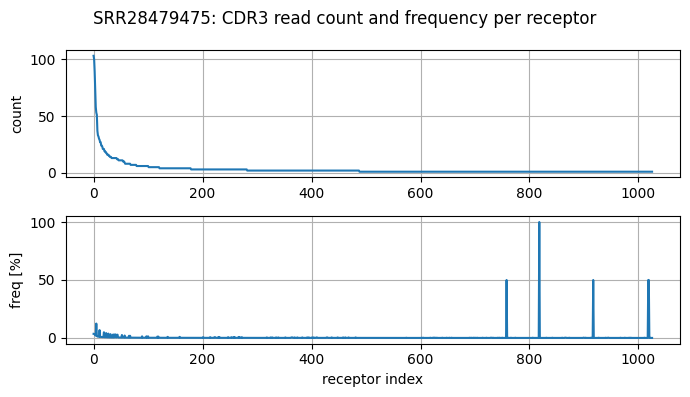

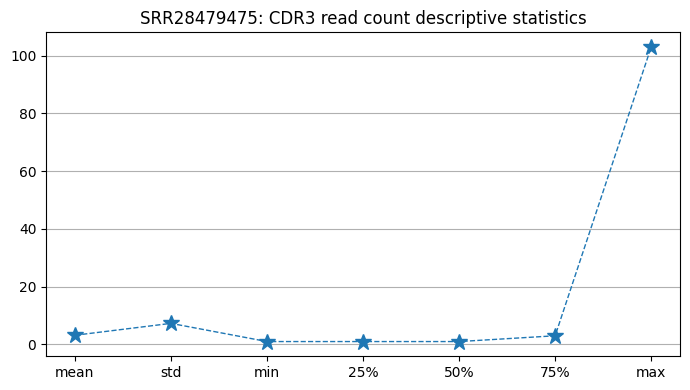

In [ ]:
''' 
Note:
- the frequency is computed as (read count of a specific TCR [BCR] CDR3 seq) / (total read count of all BCR [TCR] CDR3 seq). It
  provides information into the relative abundance of each clonotype within the immune repertoire
'''
figsize: tuple[int, int] = (7,4)
save_figure: bool = False
# -------------------------------
report_file: Path = Path(out_path) / f'TRUST_{sample_name}_report.tsv'
df = pd.read_csv(report_file, sep='\t').rename(columns={'#count': 'count'})
print(f"Report for {sample_name}:")
display(df)

print(f"- {df['cid'].unique().size:,} unique assemblies")

# number of CDR3 sequences found
num_nt_cdr3: int = df['CDR3nt'].unique().size
num_aa_cdr3: int = df['CDR3aa'].unique().size
print(f"- {num_nt_cdr3:,} ({num_aa_cdr3:,}) unique CDR3 NT (AA) sequences")

# complete VDJ variable domain
cid_full_length: pd.Series = df['cid_full_length']
print(f"- {100 * cid_full_length.sum() / cid_full_length.size:.1f}% of {cid_full_length.size:,} receptors contain complete variable domain (V(D)J)")

# read_counts and frequency
read_counts: pd.Series = df['count']
frequency: list[float] = list(100 * df['frequency'])
fig, ax = plt.subplots(nrows=2, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)
ax[0].plot(read_counts)
ax[0].grid()
ax[0].set_ylabel('count')

ax[1].plot(frequency)
ax[1].grid()
ax[1].set_ylabel('freq [%]')
ax[1].set_xlabel('receptor index')
fig.suptitle(f'{sample_name}: CDR3 read count and frequency per receptor', fontsize=12)
if save_figure:
    fig_file: Path = figure_path / f"{sample_name}_CDR3_read_counts_and_freq.jpg"
    plt.savefig(fig_file)
    print(f"\nFigure saved in {fig_file}.")

# read count stats
stats = read_counts.describe().drop('count')
#display(stats)
stats_verbose = {x: round(v, 1) for x, v in stats.items()}
print(f"- CDR3 read count stats: {stats_verbose}")
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)
ax.plot(stats.index, list(stats.values), '--*', linewidth=1.0, markersize=12)
ax.set_title(f"{sample_name}: CDR3 read count descriptive statistics", fontsize=12)
ax.yaxis.grid()
if save_figure:
    fig_file: Path = figure_path / f"{sample_name}_CDR3_read_counts_stats.jpg"
    plt.savefig(fig_file)
    print(f"\nFigure saved in {fig_file}.")


### Clonotype 
Clonotype for TCR are the CDR3 sequence and for BCR are the cluster with the same V, J gene assignments and similar CDR3 sequences

We note that:
- most are BCR
- for a given V and J gene set, number of CDR3 sequence is in general low (mostly 1 or 2)
- can use `Bio.pairwise2` to cluster further within a V and J gene set

BCR: 113, TCR: 5

- number of BCR clonotypes >= 241


size
V            J             
IGKV3-11*01  IGKJ4*01    52
IGKV3-20*01  IGKJ1*01    39
             IGKJ2*01    35
IGKV1-39*01  IGKJ2*01    31
IGKV2-30*01  IGKJ4*01    31
...                     ...
IGHV7-4-1*01 IGHJ6*02     1
IGKV1-12*02  IGKJ1*01     1
             IGKJ3*01     1
IGKV1-13*01  IGKJ1*01     1
IGLV9-49*01  IGLJ2*01     1

[241 rows x 1 columns]

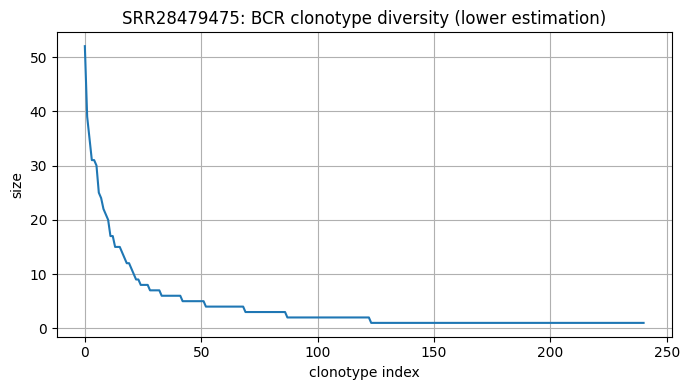

In [15]:
figsize: tuple[int, int] = (7,4)
save_figure: bool = False
# -------------------------------
v_genes = df['V'].unique().tolist()
v_genes_tcr = [v for v in v_genes if v.startswith('T')]
v_genes_bcr = [v for v in v_genes if v.startswith('I')]
print(f"BCR: {len(v_genes_bcr)}, TCR: {len(v_genes_tcr)}")

# df_tcr = df.query(f"V in {v_genes_tcr}")
df_bcr = df.query(f"V in {v_genes_bcr}")

# lower bound estimate
df_clonotype = (df_bcr[['V', 'J']]
                .query("V != '.' and J != '.'")
                .groupby(by=['V', 'J'])
                .size()
                .to_frame(name='size').sort_values(by='size', ascending=False)
                )
print(f"\n- number of BCR clonotypes >= {df_clonotype.shape[0]:,}")
display(df_clonotype)

fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)
ax.plot(df_clonotype.values)
ax.grid()
ax.set_xlabel('clonotype index')
ax.set_ylabel('size')
ax.set_title(f"{sample_name}: BCR clonotype diversity (lower estimation)", fontsize=12)
if save_figure:
    fig_file: Path = figure_path / f"{sample_name}_clonotype_diversity.jpg"
    plt.savefig(fig_file)
    print(f"\nFigure saved in {fig_file}.")

### VDJC genes diversity

- V gene: total of 119 genes: 113 BCR genes and 5 TCR genes
- D gene: total of 30 genes: 28 BCR genes and 1 TCR genes
- J gene: total of 28 genes: 23 BCR genes and 4 TCR genes
- C gene: total of 8 genes: 5 BCR genes and 2 TCR genes


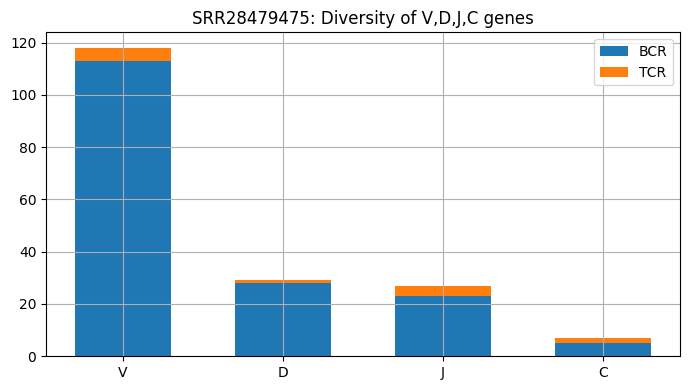

In [16]:
figsize: tuple[int, int] = (7,4)
width: float = 0.6
save_figure: bool = False
# -------------------------------
VDJC_genes_diverisity = defaultdict(list)
for gene in VDJC_genes:
    genes = df[gene].unique().tolist()
    tcr_genes = [v for v in genes if v.startswith('T')]
    bcr_genes = [v for v in genes if v.startswith('I')]
    print(f"- {gene} gene: total of {len(genes)} genes: {len(bcr_genes)} BCR genes and {len(tcr_genes)} TCR genes")
    VDJC_genes_diverisity['BCR'].append(len(bcr_genes))
    VDJC_genes_diverisity['TCR'].append(len(tcr_genes))

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)
bottom = np.zeros(len(VDJC_genes), dtype=int)
for gene, gene_bcr_tcr_count in VDJC_genes_diverisity.items():
    ax.bar(VDJC_genes, gene_bcr_tcr_count, width, label=gene, bottom=bottom)
    bottom += gene_bcr_tcr_count
ax.grid()
ax.set_title(f"{sample_name}: Diversity of {','.join(VDJC_genes)} genes", fontsize=12)
ax.legend()

if save_figure:
    fig_file: Path = figure_path / f"{sample_name}_VDJC_diversity.jpg"
    plt.savefig(fig_file)
    print(f"\nFigure saved in {fig_file}.")


### CDRs Information

- `TRUST_sample_cdr3.out` reports the CDR1,2,3 and gene information for each consensus assemblies
- contains both complete and partial CDR3 sequences, which are likely to be false positive or partially expressed V, J genes

,consensus_id,index_within_consensus,V_gene,D_gene,J_gene,C_gene,CDR1,CDR2,CDR3,CDR3_score,read_fragment_count,CDR3_germline_similarity,complete_vdj_assembly
0,assemble0,0,*,*,IGHJ4*02,IGHG1*01,*,*,ACCTCCTCCTACTACTTTGACTCCTGG,0.00,38.00,0.00,0
1,assemble1,0,"IGKV1-12*01,IGKV1D-12*02",*,IGKJ2*01,IGKC*01,*,GGTGCATCC,TGTCAACAGGCTAACAGTTTCCCGTACACTTTT,0.83,96.57,100.00,0
2,assemble1,1,"IGKV1-12*01,IGKV1D-12*02",*,IGKJ2*01,IGKC*01,*,GGTGCATCC,TGTCAACAGGCTAACAGTTTCCCGTATACTTTT,0.83,5.27,96.77,0
3,assemble1,2,"IGKV1-12*01,IGKV1D-12*02",*,IGKJ2*01,IGKC*01,*,GGTGCATCC,TGTCAACAGGCTAACAGTTTCCTGTACACTTTT,0.83,4.76,96.77,0
4,assemble1,3,"IGKV1-12*01,IGKV1D-12*02",*,IGKJ2*01,IGKC*01,*,GGTGCATCC,TGTCAACAGGCTAACAGTTTCCCTTACACTTTT,0.83,3.00,96.77,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,assemble11874,0,"IGLV5-45*01,IGLV5-48*01",*,*,*,*,*,TGTATGATTGCGCACAACAATAATTGG,0.00,1.00,0.00,0
2516,assemble11877,0,IGLV2-11*01,*,"IGLJ2*01,IGLJ3*01",*,*,*,TGCTGCTCATATGCAGGCAGTTACACTTTTCGATTC,0.67,1.00,96.77,0
2517,assemble11879,0,*,*,IGHJ6*02,*,*,*,GGGGGCTACAATAAACGAAACTACTACTACTATGGGATGGACGTCTGG,0.00,1.00,0.00,0
2518,assemble11882,0,*,*,IGLJ1*01,*,*,*,GCCGGTGGCACAACCTTTGTCTTC,0.00,1.00,0.00,0


- 2,096 unique consensus IDs
- 20 unique CDR1 sequences.	seq len stats: {'mean': 24.5, 'std': 6.7, 'min': 18.0, '25%': 18.0, '50%': 24.0, '75%': 33.0, 'max': 33.0}
- 45 unique CDR2 sequences.	seq len stats: {'mean': 11.5, 'std': 5.6, 'min': 9.0, '25%': 9.0, '50%': 9.0, '75%': 9.0, 'max': 24.0}
- 2,424 unique CDR3 sequences.	seq len stats: {'mean': 33.0, 'std': 8.2, 'min': 18.0, '25%': 27.0, '50%': 33.0, '75%': 36.0, 'max': 65.0}
- 311 unique V_gene are used
- 30 unique D_gene are used
- 53 unique J_gene are used
- 21 unique C_gene are used


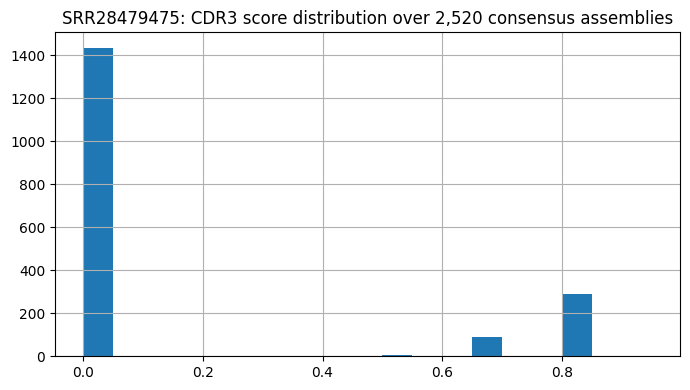

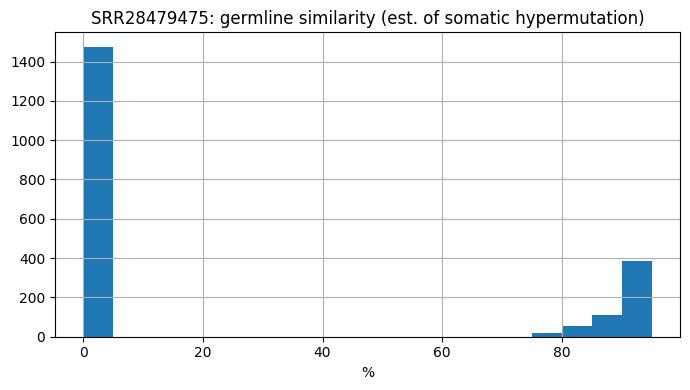

In [17]:
''' 
Note:
- index_within_consensus: due to multiple CDR3s within a single consensus sequence.
'''
figsize: tuple[int, int] = (7,4)
save_figure: bool = False
# --------------------------------
cdr3_file: Path = Path(out_path) / f'TRUST_{sample_name}_cdr3.out'
df_cdr3 = pd.read_csv(cdr3_file, sep='\t', names=CDR3_out_cols)
display(df_cdr3)

print(f"- {df_cdr3['consensus_id'].unique().size:,} unique consensus IDs")

# CDR3 score
cdr3_scores = list(df_cdr3['CDR3_score'])
# plot
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)
ax.hist(cdr3_scores, bins=list(np.arange(0, 1, 0.05, dtype=float)))
ax.grid()
ax.set_title(f"{sample_name}: CDR3 score distribution over {len(cdr3_scores):,} consensus assemblies", fontsize=12)

if save_figure:
    fig_file: Path = figure_path / f"{sample_name}_CDR3_scores.jpg"
    plt.savefig(fig_file)
    print(f"\nFigure saved in {fig_file}.")
#print("Recall that 0 score implies partial CDR3.")

# somatic hypermutation
CDR3_germline_similarity: list[float] = df_cdr3['CDR3_germline_similarity'].tolist()
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)
ax.hist(CDR3_germline_similarity, bins=list(np.arange(0, 100, 5, dtype=float)))
ax.grid()
ax.set_title(f"{sample_name}: germline similarity (est. of somatic hypermutation)", fontsize=12)
ax.set_xlabel('%')

if save_figure:
    fig_file: Path = figure_path / f"{sample_name}_germline_similarity.jpg"
    plt.savefig(fig_file)
    print(f"\nFigure saved in {fig_file}.")

# CDR3 sequence length distributions
# Note: CDR3 sequence varies in each assembly
CDRs_seq_cols: list[str] = ['CDR1', 'CDR2', 'CDR3']
for cdr_col in CDRs_seq_cols:
    cdr_seqs = df_cdr3[cdr_col]
    cdr_seq_lens = cdr_seqs.apply(len)
    cdr_seq_lens = cdr_seq_lens[cdr_seq_lens>1]
    stats = cdr_seq_lens.describe().drop('count')
    stats_verbose = {x: round(v, 1) for x, v in stats.items()}
    print(f"- {cdr_seqs.unique().size:,} unique {cdr_col} sequences.\tseq len stats: {stats_verbose}")

# genes usage
for gene in [f"{g}_gene" for g in VDJC_genes]:
    print(f"- {df_cdr3[gene].unique().size:,} unique {gene} are used")


<a id="resultsum"></a>
## Results Summary

**<u>SRR28479473</u>** (19.9M spots, 1.5G bases)
- 450 unique assemblies
- 638 (525) unique CDR3 NT (AA) sequences
- 4.0% of 642 receptors contain complete variable domain (V(D)J)
- CDR3 read count stats: {'mean': 4.2, 'std': 10.3, 'min': 1.0, '25%': 1.0, '50%': 2.0, '75%': 3.0, 'max': 125.0}
- number of BCR clonotypes >= 174
- V gene: total of 80 genes: 78 BCR genes and 1 TCR genes
- D gene: total of 27 genes: 26 BCR genes and 0 TCR genes
- J gene: total of 23 genes: 21 BCR genes and 1 TCR genes
- C gene: total of 9 genes: 7 BCR genes and 1 TCR genes
- 17 unique CDR1 sequences.	seq len stats: {'mean': 25.4, 'std': 6.9, 'min': 18.0, '25%': 18.0, '50%': 24.0, '75%': 33.0, 'max': 36.0}
- 38 unique CDR2 sequences.	seq len stats: {'mean': 13.8, 'std': 7.0, 'min': 8.0, '25%': 9.0, '50%': 9.0, '75%': 24.0, 'max': 30.0}


**<u>SRR28479474</u>** (37.3M spots, 2.8G bases)
- 232 unique assemblies
- 335 (272) unique CDR3 NT (AA) sequences
- 0.0% of 340 receptors contain complete variable domain (V(D)J)
- CDR3 read count stats: {'mean': 5.2, 'std': 8.2, 'min': 1.0, '25%': 1.0, '50%': 2.0, '75%': 5.0, 'max': 58.0}
- number of BCR clonotypes >= 109
- V gene: total of 73 genes: 63 BCR genes and 9 TCR genes
- D gene: total of 17 genes: 15 BCR genes and 1 TCR genes
- J gene: total of 25 genes: 16 BCR genes and 8 TCR genes
- C gene: total of 7 genes: 4 BCR genes and 2 TCR genes
- 6 unique CDR1 sequences.	seq len stats: {'mean': 22.1, 'std': 5.7, 'min': 18.0, '25%': 18.0, '50%': 18.0, '75%': 28.5, 'max': 30.0}
- 17 unique CDR2 sequences.	seq len stats: {'mean': 12.6, 'std': 6.1, 'min': 9.0, '25%': 9.0, '50%': 9.0, '75%': 18.0, 'max': 24.0}


**<u>SRR28479475</u>** (21.3M spots, 1.6G bases)
- 701 unique assemblies
- 1,015 (826) unique CDR3 NT (AA) sequences
- 3.8% of 1,026 receptors contain complete variable domain (V(D)J)
- CDR3 read count stats: {'mean': 3.2, 'std': 7.3, 'min': 1.0, '25%': 1.0, '50%': 1.0, '75%': 3.0, 'max': 103.0}
- number of BCR clonotypes >= 241
- V gene: total of 119 genes: 113 BCR genes and 5 TCR genes
- D gene: total of 30 genes: 28 BCR genes and 1 TCR genes
- J gene: total of 28 genes: 23 BCR genes and 4 TCR genes
- C gene: total of 8 genes: 5 BCR genes and 2 TCR genes
- 20 unique CDR1 sequences.	seq len stats: {'mean': 24.5, 'std': 6.7, 'min': 18.0, '25%': 18.0, '50%': 24.0, '75%': 33.0, 'max': 33.0}
- 45 unique CDR2 sequences.	seq len stats: {'mean': 11.5, 'std': 5.6, 'min': 9.0, '25%': 9.0, '50%': 9.0, '75%': 9.0, 'max': 24.0}

**<u>main (and preliminary) observations</u>**
- note that `SRR28479474` > `SRR28479475` > `SRR28479473` in terms of total sequenced size
- consistency in number of sequences, genes, and clonoytpe diversity ranking among samples (`SRR28479474` < `SRR28479473` < `SRR28479475`), somewhat opposite to total sequenced size (?)
- CDR3 scores and germline similarity (measure of somatic hypermutations) ranking consistent among samples (see the `_CDR3_scores,jpg` figures)
- similar (and low) CDR3 mean read counts among samples
- similar D, J, C gene usage among samples
- V gene usage consistant with number of CDR3 sequences among samples
- `SRR28479474` contains more receptors with relatively high read count frequency (proportion of read_count mapped to specific BCR/TCR), than the other samples (see the `_CDR3_read_counts_and_freq,jpg` figures). Note that this sample ranked the lowest in terms of sequences and gene found but highest in terms of total sequenced size


[Back to Top](#table-of-contents)


# Miscellaneous

<a id="donaloaddata"></a>
## Download GEO Samples

Below we implement a SRAtoolkit interface and use it to download samples.

#### Pre-requisite
We are using the SRA toolkit to download the GEO samples:
- download the [SRA toolkit](https://github.com/ncbi/sra-tools/wiki/01.-Downloading-SRA-Toolkit) (choose the right architecture)
- once downloaded, execute (example here is form MAC with ARM CPU) `tar -xzvf sratoolkit.3.2.1-mac-arm64.tar`

The SRA toolkit resides in `./Tools/sratoolkit.3.2.1/bin` folder.

#### Retrieve a GEO sample ID
1. Go to the GEO [Dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE262648)
1. Click on a sample from the `Samples` row (e.g., `GSM8172959`)
1. Click on the SRA accession number at the bottom (under `Relations`). This will open the corresponding SRA page. Copy the corresponding SRA run accession (e.g. `SRR28479474`)
1. Use the retreived SRA run accession below


In [ ]:
# This should move to a ./Util/SRAtoolkit_api.py file.

class SRAtoolkit():
    """SRA toolkit Interface."""
    def __init__(self, sra_accession: str, folder: Path,
                 sratoolkit_bin_folder: Path = Path('./Tools/sratoolkit.3.2.1/bin')) -> None:
        """Interface.

        Args:
            sra_accession (str): the SRA run accession number (e.g. SRR28479474).
            folder (Path): destination folder (will hold the .sra, .bam, abd .fastaq files).
            sratoolkit_bin_folder (Path, optional): path to sratoolkit bin/ folder. Defaults to Path('./Tools/sratoolkit.3.2.1/bin').
        """
        self.sra_accession: str = sra_accession
        self.folder: Path = folder
        self.sratoolkit_bin_folder: Path = sratoolkit_bin_folder
        self.sra_file: Path = folder / f"{sra_accession}.sra"

    def stats(self) -> str:
        """Returns the stats of the sample in XML formatted string."""
        command: str = f"{self.sratoolkit_bin_folder}/sra-stat -x {self.sra_accession}"
        try:
            _, stdout, _ = run_command(command)
        except subprocess.CalledProcessError as e:
            print(f"stats failed: {e}")
            print(f"Error output: {e.stderr}")
        return stdout
    
    def info(self) -> str:
        """Returns the sample information."""
        command: str = f"{self.sratoolkit_bin_folder}/vdb-dump --info {self.sra_accession}"
        try:
            _, stdout, _ = run_command(command)
        except subprocess.CalledProcessError as e:
            print(f"info failed: {e}")
            print(f"Error output: {e.stderr}")
        return stdout

    def prefetch(self) -> CommandOut:
        """Downloads the .sra file."""
        command: str = f"{self.sratoolkit_bin_folder}/prefetch -o {self.sra_file} {self.sra_accession}"
        try:
            ret, stdout, stderr = run_command(command)
        except subprocess.CalledProcessError as e:
            print(f"prefetch failed: {e}")
            print(f"Error output: {e.stderr}")
        return ret, stdout, stderr 
    
    def gen_fastaq(self, temp_folder: Path | None = None) -> CommandOut:
        """Generates fastaq file(s) from the .sra file.

        Args:
            temp_folder (Path | None, optional): temporary folder. Defaults to the data folder.

        Returns:
            CommandOut: command output.
        """
        if temp_folder is None:
            temp_folder = self.folder
        command: str = f"{self.sratoolkit_bin_folder}/fasterq-dump {self.sra_file} -t {temp_folder} -O {self.folder}"
        try:
            ret, stdout, stderr = run_command(command)
        except subprocess.CalledProcessError as e:
            print(f"generating fastaq failed: {e}")
            print(f"Error output: {e.stderr}")
        return ret, stdout, stderr
    
    def gen_bam(self, samtools_exe: str, remove_sam: bool = True) -> tuple[CommandOut, CommandOut]:
        """Generates the BAM file from the .sra file. Note that a SAM file is generated first.

        Args:
            samtools_exe (str): samtool execution command (used to convert the SAM file to BAM file).
            remove_sam (bool, optional): remove the SAM file after generating the BAM file. Defaults to True.

        Returns:
            tuple[CommandOut, CommandOut]: SAM generation and conversion to BAM commands output.
        """
        # gen the sam file
        sam_file = self.sra_file.with_suffix('.sam')
        command: str = f"{self.sratoolkit_bin_folder}/sam-dump {self.sra_file} > {sam_file}"
        try:
            rets, stdouts, stderrs = run_command(command)
        except subprocess.CalledProcessError as e:
            print(f"generating sam failed: {e}")
            print(f"Error output: {e.stderr}")

        # convert to bam
        bam_file = sam_file.with_suffix('.bam')
        command: str = f"{samtools_exe} view -bS {sam_file} > {bam_file}"
        try:
            retb, stdoutb, stderrb = run_command(command)
        except subprocess.CalledProcessError as e:
            print(f"generating bam failed: {e}")
            print(f"Error output: {e.stderr}")

        # remove sam
        if remove_sam:
            sam_file.unlink()

        return (rets, stdouts, stderrs), (retb, stdoutb, stderrb)

    def cleanup(self) -> None:
        """Removes the .sra file."""
        if self.sra_file.is_file():
            self.sra_file.unlink()

    def prefetch_bam(self, samtools_exe: str, remove_sam: bool = True) -> None:
        """Wrapper to prefetch and gen_bam"""
        self.prefetch()
        self.gen_bam(samtools_exe, remove_sam=remove_sam)
        self.cleanup()

    def prefetch_fastaq(self, temp_folder: Path | None = None) -> None:
        """Wrapper to prefetch and gen_fastaq"""
        self.prefetch()
        self.gen_fastaq(temp_folder=temp_folder)
        self.cleanup()

    def __repr__(self) -> str:
        return f"SRAtoolkit('{self.sra_accession}', '{self.folder}')"

    def __str__(self) -> str:
        return "SRA toolkit interface.\n"


In [ ]:
''' 
Fetch a sample and generate the bam/fastaq files.
'''
sra_sample_accession: str = 'SRR28479473'  # run accession number
# ----------------------------------------------------------------
srat = SRAtoolkit(sra_sample_accession, Path(data_path))

# another option is to inspect the stats xml file
aligned = 'align' in srat.info()
print(f"{sra_sample_accession} contains {'aligned' if aligned else 'un-aligned'} data.")

# prefetch
ret, stdout, stderr = srat.prefetch()
print(ret, stdout, stderr)

if aligned:
    # generate bam
    (rets, stdouts, stderrs), (retb, stdoutb, stderrb) = srat.gen_bam(samtools_path)
    print(rets, stdouts, stderrs, retb, stdoutb, stderrb)
else:
    # generate fastaq
    ret, stdout, stderr = srat.gen_fastaq()
    print(ret, stdout, stderr)
srat.cleanup()